In [1]:
import sqlite3
import pandas
con = sqlite3.connect('coal.db')
labels = pandas.read_sql("select orispl_code, unitid from data group by orispl_code, unitid", con)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
names = {}
for i, row in labels.iterrows():
    key = (row['orispl_code'], row['unitid'])
    for year in range(2001, 2017):
        frame = pandas.read_csv('cf/' + str(row['orispl_code']) + '_' + row['unitid'] + '_' + str(year) + '.csv')
        if len(frame.name) is 0: continue
        name = frame.name[0]
        names[key] = name
#         plt.gcf().clear()
#         data = frame.capacity_factor
#         plt.hist(data, bins=np.linspace(0, 1, 10))
#         plt.xlabel('Capacity factor - hourly generation / max hourly generation')
#         plt.ylabel('Frequency')
#         plt.title('Capacity Factors at ' + name + ', unit ' + row['unitid'] + ' in ' + str(year))
#         plt.savefig('cf/' + str(row['orispl_code']) + '_' + row['unitid'] + '_' + str(year) + '.png')

In [13]:
data = {}
for i, row in labels.iterrows():
    key = (names[(row['orispl_code'], row['unitid'])], row['unitid'])
    data[key] = {}
    for year in range(2001, 2017):
        data[key][year] = []
        frame = pandas.read_csv('cf/' + str(row['orispl_code']) + '_' + row['unitid'] + '_' + str(year) + '.csv')
        cfs = frame.capacity_factor
        dates = frame.op_date.unique()
        for date in dates:
            col = cfs[(frame.op_date == date)]
            if len(col) is 0: continue
            data[key][year].append((np.average(col), np.std(col), np.std(col/np.average(col)), len(col), col))
#         col = col[(col != 0)] This line removes nonzero values from all columns

In [32]:
import math
import scipy.stats as stats
def compare_years(year1, year2, alpha = .05):
    ttests = []
    passes_t = []
    ftests = []
    passes_f = []
    passes_list = []
    for unit in data:
        disregard = False
        if year1 not in data[unit]:
            disregard = True
        if year2 not in data[unit]:
            disregard = True
        if disregard: continue
        
        min_year =  data[unit][year1]
        max_year = data[unit][year2]    
        
        averages_min = []
        stds_min = []
        for day in min_year:
            averages_min.append(day[0])
            stds_min.append(day[1])
        averages_max = []
        stds_max = []
        for day in max_year:
            averages_max.append(day[0])
            stds_max.append(day[1])
        mean_ttest = stats.ttest_ind(averages_max, averages_min, equal_var=False).pvalue
        std_ttest = stats.ttest_ind(stds_max, stds_min, equal_var=False).pvalue
        
#         plt.gcf().clear()
#         plt.hist(stds_min, bins=np.linspace(0, 1, 20))
#         plt.xlabel('Std of hourly capacity factor over a day')
#         plt.ylabel('Frequency')
#         plt.title('Standard Deviation of Capacity Factor at ' + str(unit) + ' in ' + str(year1))
#         plt.show()
#         plt.gcf().clear()
#         plt.hist(stds_max, bins=np.linspace(0, 1, 20))
#         plt.xlabel('Std of hourly capacity factor over a day')
#         plt.ylabel('Frequency')
#         plt.title('Standard Deviation of Capacity Factor at ' + str(unit) + ' in ' + str(year2))
#         plt.show()
#         break


        if math.isnan(mean_ttest) or math.isnan(std_ttest):
            continue
        passes_t.append(mean_ttest >= alpha)
        ttests.append(mean_ttest)
        passes_f.append(std_ttest >= alpha)
        if (std_ttest >= alpha): passes_list.append(unit)
        ftests.append(std_ttest)
#     print ttests    
        
    plt.gcf().clear()
    plt.hist(ttests, bins=np.linspace(0, 1, 20))
    plt.xlabel('P value from t test')
    plt.ylabel('Frequency')
    plt.title('P value from t test between years ' + str(year1) + " and " + str(year2))
    plt.show()
    
    plt.gcf().clear()
    plt.hist(passes_t)
    plt.title('P value from t test >= ' + str(alpha))
    plt.ylabel('Frequency')
    plt.xlabel('True (1) or False (0)')
    plt.show()
        
    plt.gcf().clear()
    plt.hist(ftests, bins=np.linspace(0, 1, 20))
    plt.xlabel('P value from f test')
    plt.ylabel('Frequency')
    plt.title('P value from f test between years ' + str(year1) + " and " + str(year2))
    plt.show()
        
    plt.gcf().clear()
    plt.hist(passes_f)
    plt.title('P value from f test >= ' + str(alpha))
    plt.ylabel('Frequency')
    plt.xlabel('True (1) or False (0)')
    plt.show()
    
    print passes_list

        
# compare_years(2001, 2011)

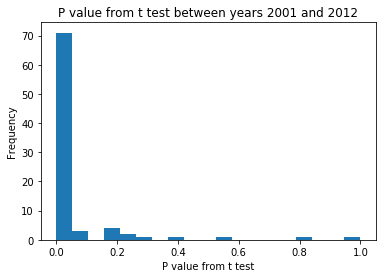

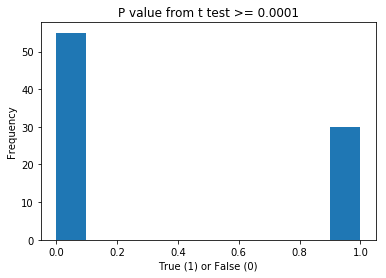

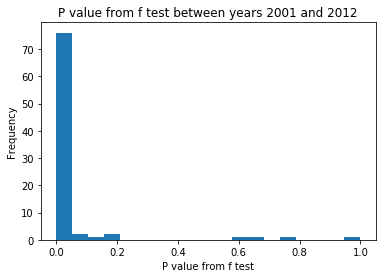

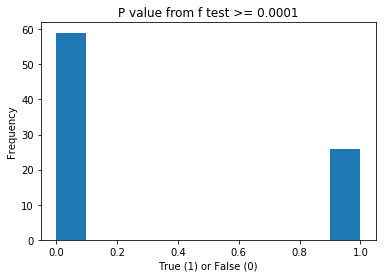

[('Arapahoe', u'3'), ('Dave Johnston', u'BW44'), ('Jim Bridger', u'BW72'), ('San Juan', u'2'), ('Jim Bridger', u'BW74'), ('Four Corners Steam Elec Station', u'3'), ('Martin Drake', u'5'), ('Comanche (470)', u'1'), ('Four Corners Steam Elec Station', u'1'), ('Rawhide Energy Station', u'101'), ('Coronado Generating Station', u'U1B'), ('Centralia', u'BW22'), ('Springerville Generating Station', u'2'), ('Jim Bridger', u'BW71'), ('Cholla', u'4'), ('Cherokee', u'3'), ('Coronado Generating Station', u'U2B'), ('Four Corners Steam Elec Station', u'2'), ('Nucla', u'1'), ('Naughton', u'1'), ('Centralia', u'BW21'), ('Dave Johnston', u'BW43'), ('Ray D Nixon', u'1'), ('Neil Simpson II', u'001'), ('Reid Gardner', u'1'), ('Naughton', u'3')]


In [38]:
compare_years(2001, 2012, .0001)